# 📊 Executive Summary: Lending Portfolio Risk Audit

---

## Project Objective

This analysis stress-tests traditional credit risk metrics (FICO Score and Loan Grade) against real-world performance data (LendingClub). The goal is to identify **systematic failures** in the traditional risk model that present a clear, profitable opportunity for an AI-driven lending platform (Upstart) to drive partner success and minimize unexpected losses.

---

## Key Findings & Strategic Insights

The analysis demonstrates that, while the overall grading system is generally sound, it **fails catastrophically** when evaluating the specific risk of purpose-driven loans for high-Fcredit borrowers:

### 1. Debunking the "Volume Trap"

* The highest **volume (raw count)** of defaults among Prime borrowers (FICO $\ge$ 750) was in Debt Consolidation loans.
* However, the **normalized default rate** for Debt Consolidation was low (4.2%), confirming it is a relatively safe, high-volume product.

### 2. Identifying the Hidden Risk (The Anomaly)

* The true operational failure is concentrated in the **Small Business loan** category.
* For borrowers with **Prime FICO scores ($\ge$ 750)**, Small Business loans default at a rate of **10.6%**. This is more than **double the average rate** for the peer group.
* **Strategic Conclusion:** The traditional FICO model fails to capture the inherent risk of entrepreneurship, even for 'Prime' borrowers. This segment represents a significant blind spot and a prime target for a next-generation AI risk model.

---

## Technical Stack

* **Language:** Python
* **Libraries:** Pandas (Data Cleaning, Aggregation, SQL-style Merge), Seaborn/Matplotlib (Visualization)
* **Methodology:** Comparative Risk Analysis, Statistical Filtering (`.groupby().agg().mean()`), Volume-Adjusted Rate Calculation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [2]:
columns_to_keep = [
    'loan_amnt',
    'term',
    'int_rate',
    'grade',
    'emp_length',
    'home_ownership',
    'annual_inc',
    'purpose',
    'fico_range_low',
    'loan_status'
]

accepted = pd.read_csv('archive/accepted_2007_to_2018Q4.csv/accepted_2007_to_2018Q4.csv', usecols=columns_to_keep)

print("Success! loaded", accepted.shape)

Success! loaded (2260701, 10)


In [3]:
accepted.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,loan_status,purpose,fico_range_low
0,3600.0,36 months,13.99,C,10+ years,MORTGAGE,55000.0,Fully Paid,debt_consolidation,675.0
1,24700.0,36 months,11.99,C,10+ years,MORTGAGE,65000.0,Fully Paid,small_business,715.0
2,20000.0,60 months,10.78,B,10+ years,MORTGAGE,63000.0,Fully Paid,home_improvement,695.0
3,35000.0,60 months,14.85,C,10+ years,MORTGAGE,110000.0,Current,debt_consolidation,785.0
4,10400.0,60 months,22.45,F,3 years,MORTGAGE,104433.0,Fully Paid,major_purchase,695.0


In [4]:
rejected = pd.read_csv('archive/rejected_2007_to_2018q4.csv/rejected_2007_to_2018q4.csv')

print('Success! loaded', rejected.shape)

Success! loaded (27648741, 9)


In [5]:
rejected.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


## calculating the default rate for each letter grade

In [6]:
accepted['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [7]:
accepted['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [8]:
def label_default(status):
    if status in ['Fully Paid', 'Current']:
        return 0
    elif status in (['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)',
                     'Does not meet the credit policy. Status:Charged Off',
                     'Default']):
        return 1
    else:
        return None # treating In Grace Period as an NaN for this analysis
    
accepted['is_default'] = accepted['loan_status'].apply(label_default)

accepted.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,loan_status,purpose,fico_range_low,is_default
0,3600.0,36 months,13.99,C,10+ years,MORTGAGE,55000.0,Fully Paid,debt_consolidation,675.0,0.0
1,24700.0,36 months,11.99,C,10+ years,MORTGAGE,65000.0,Fully Paid,small_business,715.0,0.0
2,20000.0,60 months,10.78,B,10+ years,MORTGAGE,63000.0,Fully Paid,home_improvement,695.0,0.0
3,35000.0,60 months,14.85,C,10+ years,MORTGAGE,110000.0,Current,debt_consolidation,785.0,0.0
4,10400.0,60 months,22.45,F,3 years,MORTGAGE,104433.0,Fully Paid,major_purchase,695.0,0.0


In [9]:
accepted['is_default'].value_counts()

0.0    1955068
1.0     295176
Name: is_default, dtype: int64

In [10]:
risk_df = accepted.groupby('grade', as_index=False).agg(
    risk_by_grade = ('is_default', 'mean')
)

risk_df['risk_by_grade'] = (risk_df['risk_by_grade'] * 100)

risk_df

,grade,risk_by_grade
0,A,3.672639
1,B,8.834542
2,C,14.667195
3,D,20.803587
4,E,28.831194
5,F,37.081582
6,G,41.083389


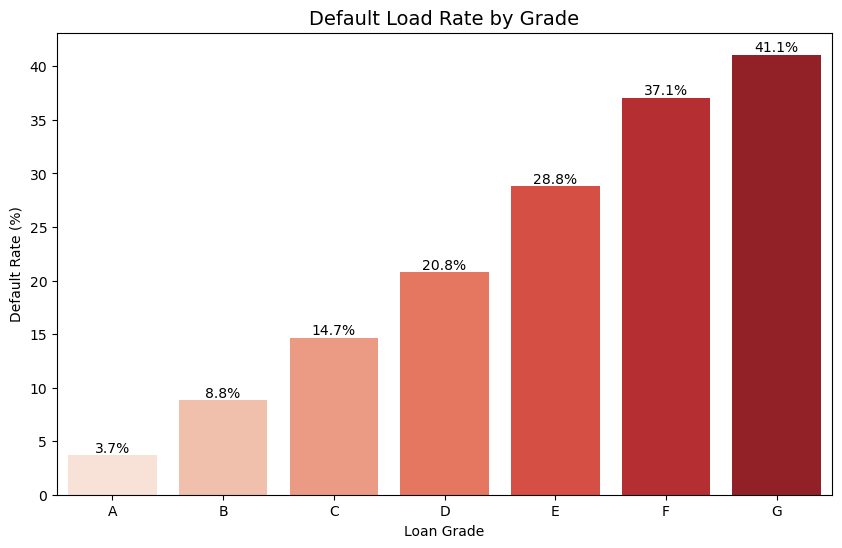

In [11]:
plt.figure(figsize=(10,6))

ax = sns.barplot(x='grade', y='risk_by_grade', data=risk_df, palette='Reds')

plt.title('Default Load Rate by Grade', fontsize=14)
plt.xlabel('Loan Grade', fontsize=10)
plt.ylabel('Default Rate (%)', fontsize=10)

for i in ax.containers:
    ax.bar_label(i, fmt='%.1f%%')

plt.show()

In [12]:
display_table = risk_df.copy()
display_table['risk_by_grade'] = display_table['risk_by_grade'].map('{:.2f}%'.format)
display_table

,grade,risk_by_grade
0,A,3.67%
1,B,8.83%
2,C,14.67%
3,D,20.80%
4,E,28.83%
5,F,37.08%
6,G,41.08%


## Which loan products are risky?

In [13]:
accepted.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,loan_status,purpose,fico_range_low,is_default
0,3600.0,36 months,13.99,C,10+ years,MORTGAGE,55000.0,Fully Paid,debt_consolidation,675.0,0.0
1,24700.0,36 months,11.99,C,10+ years,MORTGAGE,65000.0,Fully Paid,small_business,715.0,0.0
2,20000.0,60 months,10.78,B,10+ years,MORTGAGE,63000.0,Fully Paid,home_improvement,695.0,0.0
3,35000.0,60 months,14.85,C,10+ years,MORTGAGE,110000.0,Current,debt_consolidation,785.0,0.0
4,10400.0,60 months,22.45,F,3 years,MORTGAGE,104433.0,Fully Paid,major_purchase,695.0,0.0


In [14]:
accepted['purpose'].value_counts()

debt_consolidation    1277877
credit_card            516971
home_improvement       150457
other                  139440
major_purchase          50445
medical                 27488
small_business          24689
car                     24013
vacation                15525
moving                  15403
house                   14136
wedding                  2355
renewable_energy         1445
educational               424
Name: purpose, dtype: int64

In [15]:
product_risk =    accepted.groupby('purpose', as_index=False).agg(
                    product_risk_pct = ('is_default', lambda x: x.mean() * 100)
                  ).sort_values('product_risk_pct')

product_risk

,purpose,product_risk_pct
0,car,9.959392
1,credit_card,10.657867
4,home_improvement,11.580170
6,major_purchase,12.307355
12,vacation,12.478191
13,wedding,12.629758
5,house,13.018089
9,other,13.294652
7,medical,13.727785
2,debt_consolidation,14.175624


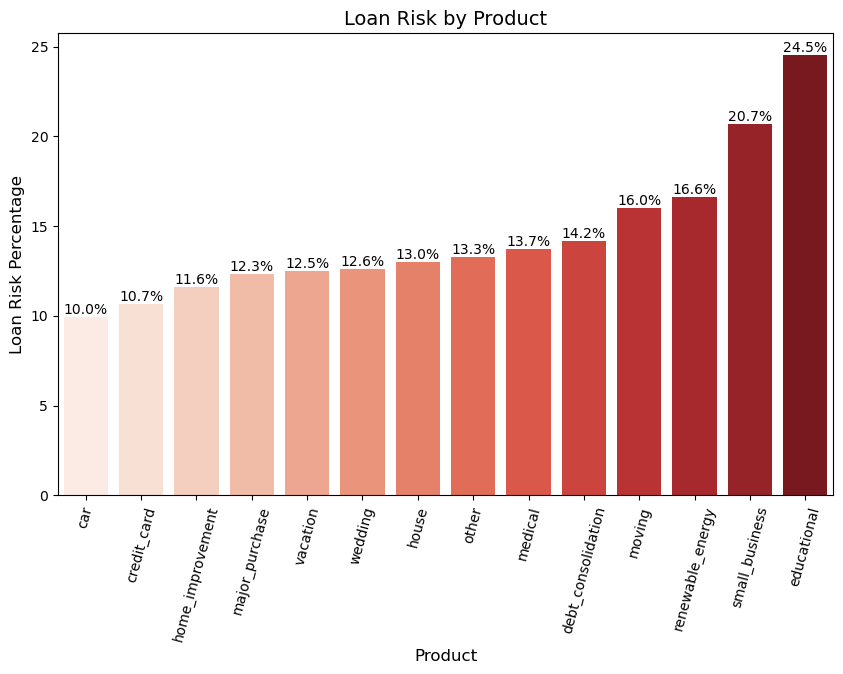

In [16]:
plt.figure(figsize=(10,6))

ax = sns.barplot(x='purpose', y='product_risk_pct', data=product_risk, palette='Reds')

plt.title('Loan Risk by Product', fontsize=14)
plt.xticks(rotation=75)
plt.xlabel('Product', fontsize=12)
plt.ylabel('Loan Risk Percentage', fontsize=12)

for i in ax.containers:
    ax.bar_label(i, fmt='%.1f%%')


plt.show()

In [17]:
small_business_risk_by_grade = (accepted[accepted['purpose'] == 'small_business']
                                 .groupby('grade', as_index=False).agg(
                                    risk_by_grade = ('is_default', lambda x: x.mean() * 100),
                                    count_by_grade = ('is_default', 'count')
                                ))

total_business_count = len(accepted[accepted['purpose'] == 'small_business'])

small_business_risk_by_grade['count_pct'] = (small_business_risk_by_grade['count_by_grade'] / total_business_count) * 100

small_business_risk_by_grade

,grade,risk_by_grade,count_by_grade,count_pct
0,A,7.142857,2954,11.964843
1,B,12.662405,4849,19.640326
2,C,17.751926,6619,26.809510
3,D,25.038670,5172,20.948601
4,E,32.953784,2986,12.094455
5,F,39.285714,1316,5.330309
6,G,44.856661,593,2.401879


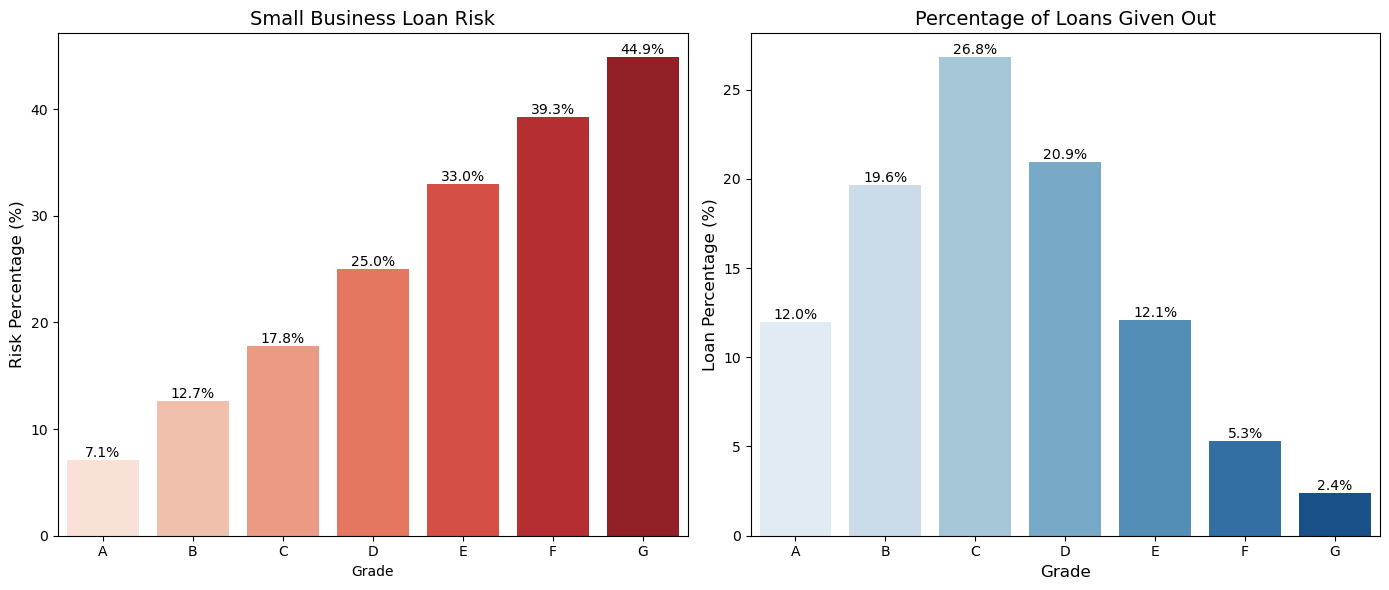

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6), sharey=False)

# --- CHART 1: RISK
sns.barplot(x='grade', y='risk_by_grade', data=small_business_risk_by_grade, palette='Reds', ax=ax1)

ax1.set_title('Small Business Loan Risk', fontsize=14)
ax1.set_ylabel('Risk Percentage (%)', fontsize=12)
ax1.set_xlabel('Grade')

# --- CHART 2: Volume
sns.barplot(x='grade', y='count_pct', data=small_business_risk_by_grade, palette='Blues', ax=ax2)

ax2.set_title('Percentage of Loans Given Out', fontsize=14)
ax2.set_ylabel('Loan Percentage (%)', fontsize=12)
ax2.set_xlabel('Grade', fontsize=12)

for ax in [ax1, ax2]:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.show()

In [19]:
total_ed_count = len(accepted[accepted['purpose'] == 'educational'])

educational_risk_by_grade = (accepted[accepted['purpose'] == 'educational']
                             .groupby('grade', as_index=False)
                             .agg(
                                 risk_by_grade = ('is_default', lambda x: x.mean() * 100),
                                 count = ('is_default', 'count'),
                             )
                            )

educational_risk_by_grade['count_pct'] = (educational_risk_by_grade['count'] / total_ed_count) * 100

educational_risk_by_grade

,grade,risk_by_grade,count,count_pct
0,A,6.172840,81,19.103774
1,B,20.192308,104,24.528302
2,C,22.772277,101,23.820755
3,D,45.000000,40,9.433962
4,E,65.217391,23,5.424528
5,F,62.500000,8,1.886792
6,G,50.000000,2,0.471698


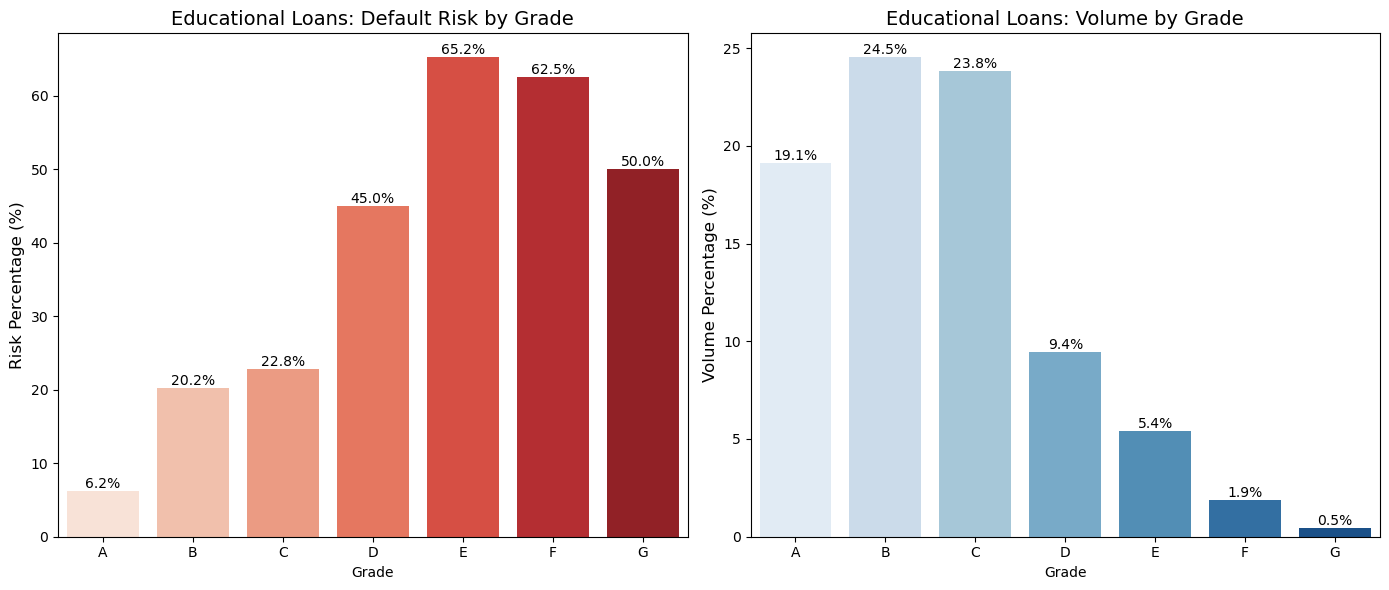

In [20]:
# Create the subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6)) 

# --- CHART 1: RISK
sns.barplot(x='grade', y='risk_by_grade', data=educational_risk_by_grade, palette='Reds', ax=ax1)

ax1.set_title('Educational Loans: Default Risk by Grade', fontsize=14)
ax1.set_ylabel('Risk Percentage (%)', fontsize=12)
ax1.set_xlabel('Grade')

# --- CHART 2: VOLUME 
sns.barplot(x='grade', y='count_pct', data=educational_risk_by_grade, palette='Blues', ax=ax2)

ax2.set_title('Educational Loans: Volume by Grade', fontsize=14)
ax2.set_ylabel('Volume Percentage (%)', fontsize=12)
ax2.set_xlabel('Grade')

for ax in [ax1, ax2]:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.show()

In [21]:
total_ed_count

424

In [22]:
accepted[(accepted['purpose'] == 'educational') & (accepted['grade'] == 'E')].value_counts('is_default')

is_default
1.0    15
0.0     8
dtype: int64

## FICO vs. Interest Rates

In [23]:
accepted.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,loan_status,purpose,fico_range_low,is_default
0,3600.0,36 months,13.99,C,10+ years,MORTGAGE,55000.0,Fully Paid,debt_consolidation,675.0,0.0
1,24700.0,36 months,11.99,C,10+ years,MORTGAGE,65000.0,Fully Paid,small_business,715.0,0.0
2,20000.0,60 months,10.78,B,10+ years,MORTGAGE,63000.0,Fully Paid,home_improvement,695.0,0.0
3,35000.0,60 months,14.85,C,10+ years,MORTGAGE,110000.0,Current,debt_consolidation,785.0,0.0
4,10400.0,60 months,22.45,F,3 years,MORTGAGE,104433.0,Fully Paid,major_purchase,695.0,0.0


In [24]:
accepted['int_rate'].value_counts()

11.99    53869
5.32     47171
10.99    44165
13.99    43025
11.49    32010
         ...  
24.59        1
24.40        1
16.83        1
17.72        1
14.28        1
Name: int_rate, Length: 673, dtype: int64

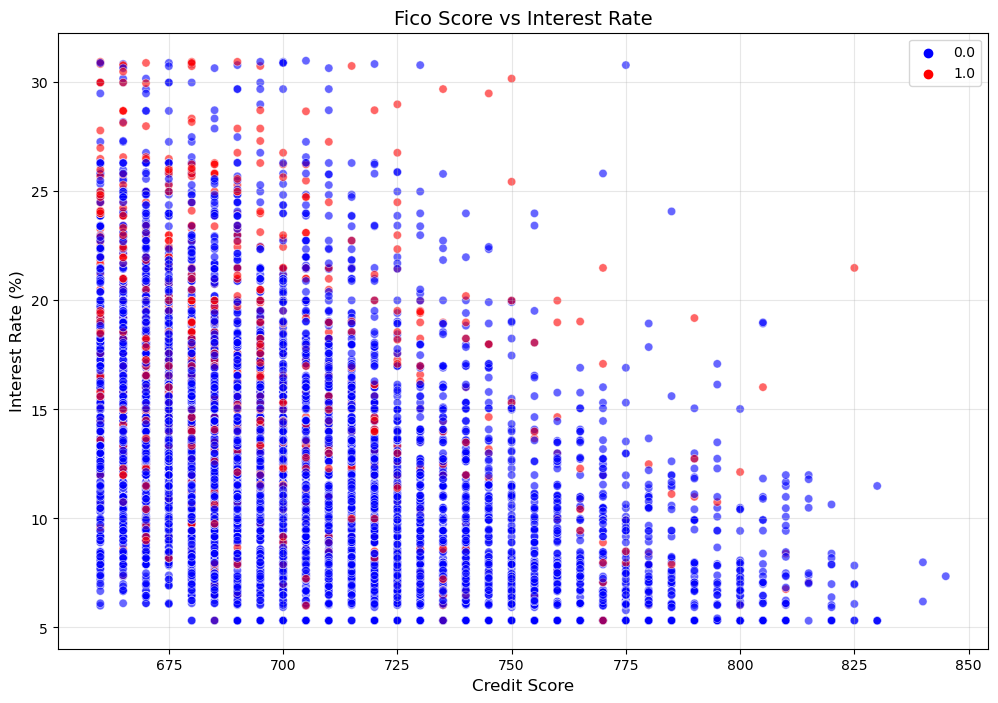

In [33]:
plt.figure(figsize=(12,8))

(sns.scatterplot(data=accepted.sample(10000, random_state=42),
                 x='fico_range_low', 
                 y='int_rate',
                 palette = {0:'blue', 1:'red'},
                 alpha=0.6,
                 hue='is_default')
)

plt.title('Fico Score vs Interest Rate', fontsize=14)
plt.xlabel('Credit Score', fontsize=12)
plt.ylabel('Interest Rate (%)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

### Seeing what types of loans defaulted for people with a credit score of 750 and above

In [26]:
default_over_750 = accepted[(accepted['fico_range_low'] > 750) & (accepted['is_default'] == 1)]

default_over_750.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,loan_status,purpose,fico_range_low,is_default
1065,18000.0,36 months,11.48,B,10+ years,RENT,86000.0,Charged Off,medical,755.0,1.0
1265,13600.0,36 months,15.77,D,4 years,OWN,40000.0,Charged Off,debt_consolidation,775.0,1.0
1968,3500.0,36 months,16.59,D,4 years,RENT,48000.0,Charged Off,vacation,755.0,1.0
2184,35000.0,60 months,9.80,B,10+ years,MORTGAGE,105000.0,Charged Off,debt_consolidation,765.0,1.0
2401,21125.0,60 months,17.97,D,3 years,RENT,120000.0,Charged Off,medical,770.0,1.0


In [27]:
default_graph = (default_over_750.groupby('purpose', as_index=False).
                    agg(
                        default_count = ('is_default', 'count')
                    )
                ).sort_values('default_count').reset_index(drop=True)

default_graph

,purpose,default_count
0,educational,5
1,renewable_energy,15
2,wedding,16
3,moving,102
4,vacation,122
5,house,126
6,car,135
7,medical,214
8,small_business,387
9,major_purchase,635


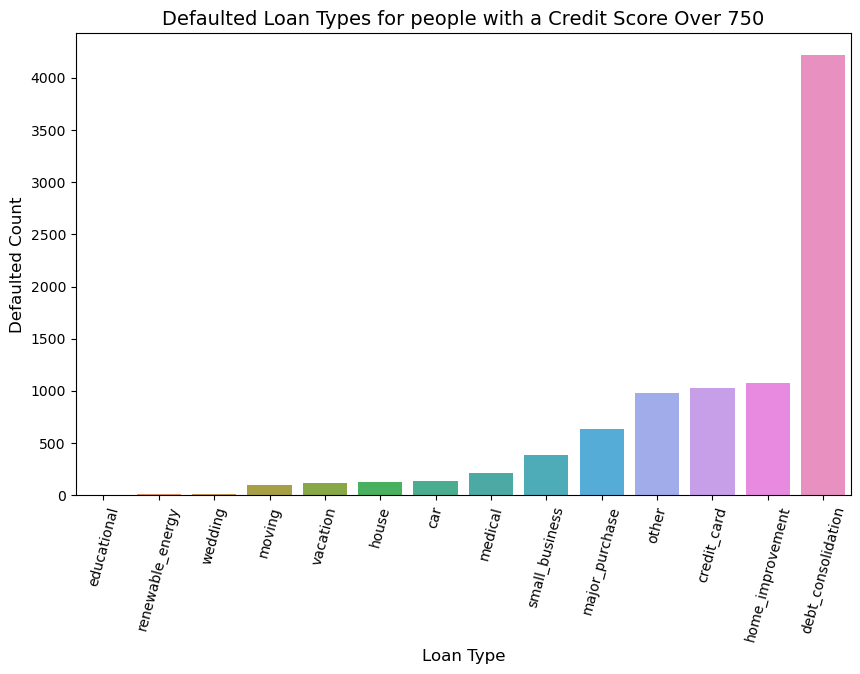

In [28]:
plt.figure(figsize=(10,6))

ax = sns.barplot(x='purpose', y='default_count', data=default_graph)

plt.title('Defaulted Loan Types for people with a Credit Score Over 750', fontsize=14)
plt.ylabel('Defaulted Count', fontsize=12)
plt.xlabel('Loan Type', fontsize=12)

plt.xticks(rotation=75)

plt.show()

In [29]:
all_high_fico = accepted[accepted['fico_range_low'] >= 750]

all_high_fico.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,loan_status,purpose,fico_range_low,is_default
3,35000.0,60 months,14.85,C,10+ years,MORTGAGE,110000.0,Current,debt_consolidation,785.0,0.0
17,18000.0,60 months,11.99,C,10+ years,MORTGAGE,112000.0,Fully Paid,debt_consolidation,800.0,0.0
26,20000.0,36 months,5.32,A,9 years,OWN,65000.0,Fully Paid,debt_consolidation,835.0,0.0
28,17600.0,36 months,5.32,A,< 1 year,MORTGAGE,88000.0,Fully Paid,credit_card,780.0,0.0
44,8650.0,36 months,5.32,A,< 1 year,MORTGAGE,100000.0,Fully Paid,credit_card,750.0,0.0


In [30]:
fico_high_loan_count =(all_high_fico.groupby('purpose', as_index=False).
                        agg(
                            purpose_count = ('purpose', 'count')
                        )
                    )

fico_high_loan_count

,purpose,purpose_count
0,car,4082
1,credit_card,39267
2,debt_consolidation,100451
3,educational,64
4,home_improvement,23495
5,house,2441
6,major_purchase,9395
7,medical,3711
8,moving,1663
9,other,16931


In [31]:
high_fico_default_pct = pd.merge(fico_high_loan_count, default_graph, on='purpose', how='left')

high_fico_default_pct['default_pct'] = (high_fico_default_pct['default_count'] / high_fico_default_pct['purpose_count']) * 100

high_fico_default_pct.sort_values('default_pct', ascending=False)

,purpose,purpose_count,default_count,default_pct
11,small_business,3644,387,10.620198
10,renewable_energy,169,15,8.875740
3,educational,64,5,7.812500
6,major_purchase,9395,635,6.758914
12,vacation,1828,122,6.673961
8,moving,1663,102,6.133494
9,other,16931,983,5.805918
7,medical,3711,214,5.766640
5,house,2441,126,5.161819
13,wedding,329,16,4.863222


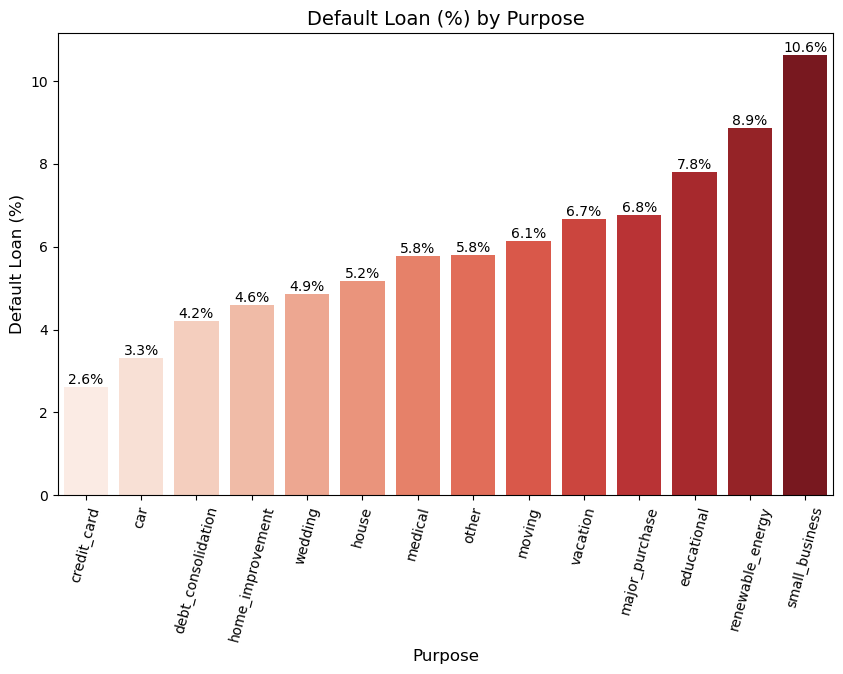

In [32]:
plt.figure(figsize=(10,6))

ax = sns.barplot(data=high_fico_default_pct.sort_values('default_pct'), x='purpose', y='default_pct', palette='Reds')

plt.xticks(rotation=75)
plt.title('Default Loan (%) by Purpose', fontsize=14)
plt.ylabel('Default Loan (%)', fontsize=12)
plt.xlabel('Purpose', fontsize=12)

for i in ax.containers:
    ax.bar_label(i, fmt=("%.1f%%"))

plt.show()